# Image segmentation using U-Net
References:
- [Guide](https://medium.com/@alessandromondin/semantic-segmentation-with-pytorch-u-net-from-scratch-502d6565910a)
- [Handling COCO dataset](https://www.kaggle.com/code/armanasgharpoor1993/coco-dataset-tutorial-image-segmentation)
- [Generating class-wise masks](https://github.com/Tramac/awesome-semantic-segmentation-pytorch/blob/master/core/data/dataloader/mscoco.py)

In [1]:
# Import necessary libraries
import numpy as np
import os, sys 
from importlib import reload
import matplotlib.pyplot as plt
import fiftyone as fo 
import fiftyone.zoo as foz
from tqdm import tqdm 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset
from  torchvision.transforms import InterpolationMode

from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask

/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset

# Save to current directory
curr_dir = os.getcwd()
fo.config.dataset_zoo_dir = curr_dir 

# Download the data 
dataset = foz.load_zoo_dataset("coco-2017",
                            splits=['train'],
                            shuffle=True,
                            seed=0,
                            max_samples=2000,
                            label_type=['segmentations'],
                            only_matching=True,
                            classes=['person', 'cat', 'car'])

Found annotations at '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Segmentation U-Net/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Ignoring unsupported parameter 'label_type' for importer type <class 'fiftyone.utils.coco.COCODetectionDatasetImporter'>
Loading existing dataset 'coco-2017-train-2000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:
class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, filter_classes, size=None, max_num=None):
        self.image_dir = image_dir
        self.filter_classes = filter_classes
        self.coco = COCO(annotation_file)
        self.coco_mask = mask 

        # Fetch class IDs only corresponding to the filterClasses
        self.catIds = self.coco.getCatIds(catNms=filter_classes)

        # Get image ID that satisfies the given filter conditions
        self.ids = self.coco.getImgIds()
        
        if max_num != None:
            self.ids = self.ids[:max_num]

        self.size = size
        if size != None:
            self.transform = T.Compose([T.Resize((size, size)), T.ToTensor()])
            self.mask_transform = T.Compose([T.Resize((size, size), interpolation=Image.NEAREST), 
                                             T.ToTensor()])
        else:
            self.transform = T.ToTensor()
            self.mask_transform = T.ToTensor()
        
        self.scale = len(self.catIds)
        
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.catIds)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        mask = np.zeros(image.size[::-1], dtype=np.uint8)
       
        # 0 is background
        for ann in anns:
            idx = self.catIds.index(ann['category_id']) + 1
            mask = np.maximum(mask, self.coco.annToMask(ann)*idx)

        # Normalize for PyTorch
        mask = Image.fromarray(mask/len(self.catIds))

        
        image = self.transform(image)
        mask = self.mask_transform(mask)
        
        return image, mask

In [4]:
# Dataset loader for PyTorch

dataDir='./coco-2017/'
dataType='train2017'
# annFile='{}raw/instances_{}.json'.format(dataDir, dataType)
annFile='{}/train/labels.json'.format(dataDir)

imageDir = '{}train/data/'.format(dataDir)
filter_classes = ['person', 'cat', 'car']
size = 128
max_num = None

# Initialize the COCO api for instance annotations
coco_dataset = COCODataset(imageDir, annFile, filter_classes, size, max_num)


loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [5]:
from torch.utils.data import random_split

train_ratio = 0.9
total_length = len(coco_dataset)
train_length = int(train_ratio * total_length)
test_length = total_length - train_length

train_dataset, test_dataset = random_split(coco_dataset, [train_length, test_length])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [6]:

class UNetBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, submodule, kernel=4, stride=2, padding=1, 
                 dropout = False, outermost = False, innermost = False):
        super(UNetBlock, self).__init__()

        down_conv = nn.Conv2d(in_channels, mid_channels, kernel_size=kernel, stride=stride, padding=padding)
        down_batchnorm = nn.BatchNorm2d(mid_channels)
        down_relu = nn.ReLU(inplace=True)
        up_batchnorm = nn.BatchNorm2d(out_channels)
        up_relu = nn.ReLU(inplace=True)

        self.outermost = outermost 

        if outermost:
            layers = [down_conv, down_batchnorm, down_relu]
            layers += [submodule]
            layers += [nn.ConvTranspose2d(mid_channels*2, out_channels, kernel_size=kernel, stride=stride, padding=padding)]
            # ## Add final activation - segmentation uses sigmoid
            # layers += [nn.Sigmoid()]
            layers += [nn.Softmax(dim=1)]
        elif innermost:
            up_conv = nn.ConvTranspose2d(mid_channels, out_channels, kernel_size=kernel, stride=stride, padding=padding)
            layers = [down_conv, down_batchnorm, down_relu]
            layers += [up_conv, up_batchnorm, up_relu]
        else: 
            up_conv = nn.ConvTranspose2d(mid_channels*2, out_channels, kernel_size=kernel, stride=stride, padding=padding)
            layers = [down_conv, down_batchnorm, down_relu]
            layers += [submodule]
            layers += [up_conv, up_batchnorm, up_relu]
            if dropout: layers += [nn.Dropout(0.4)]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], axis = 1)

class UNet(nn.Module):
    # Exit channels is number of classes
    def __init__(self, in_channels, first_out_channels, exit_channels, downhill = 4, kernel = 3, stride = 1, padding = 0):
        super(UNet, self).__init__()
        
        num_innermost = first_out_channels*(2**(downhill - 1))
        num_mid = num_innermost
        layer = UNetBlock(num_innermost, num_innermost, num_innermost, None, innermost=True)
        for _ in range(downhill - 1):
            num_mid //= 2
            layer = UNetBlock(num_mid, num_mid*2, num_mid, layer)
            
        self.model = UNetBlock(in_channels, first_out_channels, exit_channels, layer, outermost=True)

    def forward(self, x):
        return self.model(x)
        

In [7]:
# Parameters
learning_rate = 2e-3
num_epochs = 10
n_down = 4
input_channels = 3
first_out_channels = 32
output_classes = 4
device = torch.device('mps')

# 4 classes output - person, cat, car, background
model = UNet(input_channels, first_out_channels, output_classes, n_down)

# Define loss function
criterion = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='focal_loss',
    # background and person get less weight since car and cat instances are very less
	alpha=torch.tensor([0.1, 0.2, 0.35, 0.35]),
	gamma=2,
    device=device,
	reduction='mean',
    dtype=torch.float32,
	force_reload=False
)
 
# Define optimizer
optimizer = optim.Adam(model.parameters())

# Set device
model= nn.DataParallel(model)
model.to(device)


Using cache found in /Users/sudhansh/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


DataParallel(
  (module): UNet(
    (model): UNetBlock(
      (model): Sequential(
        (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): UNetBlock(
          (model): Sequential(
            (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): UNetBlock(
              (model): Sequential(
                (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
                (3): UNetBlock(
                  (model): Sequential(
                    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), pa

In [8]:
# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, masks) in tqdm(enumerate(train_loader)):
        images, masks = images.to(device), masks.to(device)

        # Convert to int masks
        masks = masks*coco_dataset.scale 
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        flattened_output = outputs.reshape([batch_size, output_classes, -1])
        flattened_masks = masks.reshape([batch_size, -1]).long()
        loss = criterion(flattened_output, flattened_masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(coco_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

0it [00:00, ?it/s]/Users/sudhansh/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master/focal_loss.py:67: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  y = y[unignored_mask]
113it [00:28,  4.00it/s]


Epoch [1/10], Loss: 0.053551


113it [00:26,  4.26it/s]


Epoch [2/10], Loss: 0.049391


113it [00:26,  4.33it/s]


Epoch [3/10], Loss: 0.048268


113it [00:26,  4.30it/s]


Epoch [4/10], Loss: 0.048273


113it [00:26,  4.26it/s]


Epoch [5/10], Loss: 0.047316


113it [00:26,  4.26it/s]


Epoch [6/10], Loss: 0.046962


113it [00:26,  4.27it/s]


Epoch [7/10], Loss: 0.046322


113it [00:26,  4.26it/s]


Epoch [8/10], Loss: 0.045680


113it [00:26,  4.23it/s]


Epoch [9/10], Loss: 0.044895


113it [00:26,  4.28it/s]

Epoch [10/10], Loss: 0.044008


In [16]:
# Save model for using trained weights in the future
torch.save(model.state_dict(), 'trained.pt')

In [17]:
def metrics(pred_mask, true_mask):
    delta = 1e-6 

    intersection = torch.sum(pred_mask & true_mask).item()
    union = torch.sum(pred_mask | true_mask).item()
    sum_areas = torch.sum(pred_mask).item() + torch.sum(true_mask).item()

    dice_score = (2*intersection)/(sum_areas + delta)
    iou_score = intersection/(union + delta)
    return dice_score, iou_score 

In [18]:
# Test model 
model.eval()
classes = {0: "background", 1: "person", 2: "car", 3: "cat"}
dice_sums = {}
iou_sums = {}

for i in range(len(classes)):
    dice_sums[i] = []
    iou_sums[i] = []
counter = 10

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        masks = masks*coco_dataset.scale 

        outputs = model(images)
        
        predicted_masks = torch.argmax(outputs, dim=1)
        
        for key, value in classes.items():
    
            class_pred = predicted_masks.flatten() == float(key)
            class_truth = masks.flatten() == float(key)

           
                
            dice, iou = metrics(class_pred, class_truth)
            
            dice_sums[key].append(dice) 
            iou_sums[key].append(iou) 

        if i == counter:
            break
mean_dice = [np.mean(scores) for scores in dice_sums.values()]
mean_iou = [np.mean(scores) for scores in iou_sums.values()]


In [20]:
# Average across all classes
print("Mean Dice Score is", np.mean(mean_dice))
print("Mean IoU Score is ", np.mean(mean_iou))

Mean Dice Score is 0.3051481561277192
Mean IoU Score is  0.2614870965656806


In [21]:
print(images.shape)
num = 0
image = images[num, ...].permute([1, 2, 0]).cpu()
print(masks.shape)
mask = masks[num, ...].reshape(size, size).cpu()
print(outputs[num, ...].shape)
output = torch.argmax(outputs, dim = 1)
gimage = image[:, :, 0] * 0.2989 + image[:, :, 1] * 0.5870 + image[:, :, 2] * 0.1140
output = output[num, ...].reshape(size, size).cpu()
print(gimage.shape, mask.shape, output.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([4, 128, 128])
torch.Size([128, 128]) torch.Size([128, 128]) torch.Size([128, 128])


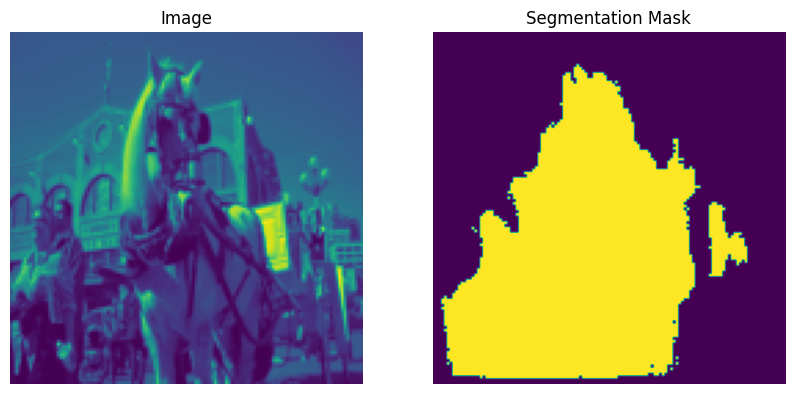

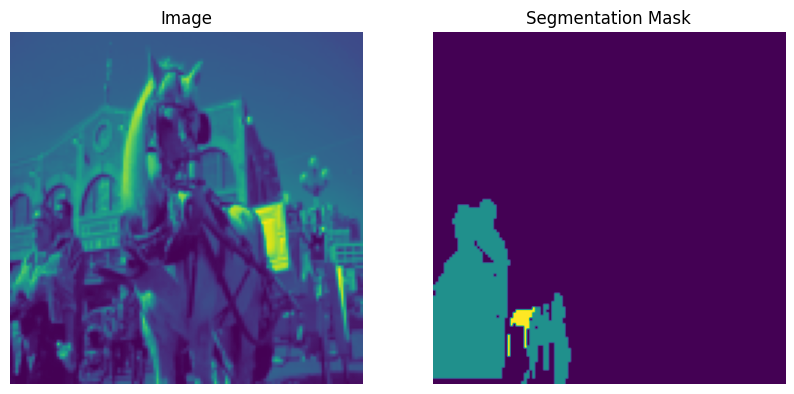

In [22]:
def visualize_segmentation(image, mask, classes=None):
    """
    Visualizes an image and its corresponding segmentation mask.
    
    Parameters:
        image (numpy.ndarray): Input image.
        mask (numpy.ndarray): Segmentation mask.
        classes (list): List of class labels. If provided, the mask will be color-coded accordingly.
    """
    plt.figure(figsize=(10, 5))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Plot the segmentation mask
    plt.subplot(1, 2, 2)
    if classes:
        colored_mask = np.zeros_like(mask, dtype=np.uint8)
        for i, label in enumerate(classes):
            colored_mask[mask == i] = label
        plt.imshow(colored_mask)
        plt.title('Segmentation Mask (Color-coded)')
    else:
        plt.imshow(mask)
        plt.title('Segmentation Mask')
    plt.axis('off')

    plt.show()

# Visualize the image and mask
visualize_segmentation(gimage, output)
visualize_segmentation(gimage, mask)

In [15]:
print(np.unique(masks[0, ...].cpu().numpy()))
print(np.unique(output.cpu().numpy()))

[0. 1. 2.]
[0 1]
